In [ ]:
wfrom affine_utils import *
import torch
import torch.nn as nn
from external.ZoeDepth.zoedepth.utils.misc import denormalize
import matplotlib.pyplot as plt
import cv2

device = 'mps'
from zoedepth.models.builder import build_model
from zoedepth.utils.config import get_config
import torch.nn.functional as F
from KITTI_virt import *

conf = get_config("zoedepth_nk", "infer")
model = build_model(conf).to('mps')

In [ ]:
weather_loader = create_virtual_kitti_dataloader(
    root_dir='../../../data',
    model_name='raw',
    worlds=['0001'],  # Tylko pierwsze dwa światy
    variations=['clone'],  # Tylko wybrane warianty
    batch_size=1,
    max_frames=3
)
test_batch = next(iter(weather_loader))
test_img = test_batch['image'].to(device)
test_depth = test_batch['ground_truth'].to(device)

In [ ]:
test_img.shape, test_depth.shape

In [4]:
result = model.infer(test_img)

In [5]:
def pnp_inference_adaptive(model, rgb_input, sparse_depth, pnp_iters=2, pnp_alpha=0.01,
                           alpha_adaptation=True, alpha_increase_factor=1.1, alpha_decrease_factor=0.8,
                           min_alpha=0.001, max_alpha=0.1, patience=2):
    """
    Plug-and-Play inference dla ZoeDepth z wykorzystaniem sparse depth i adaptacyjnym alpha

    Args:
        model: model ZoeDepth
        rgb_input: obraz RGB
        sparse_depth: sparse depth map
        pnp_iters: liczba iteracji PnP
        pnp_alpha: początkowy learning rate
        alpha_adaptation: czy włączyć adaptację alpha
        alpha_increase_factor: mnożnik zwiększania alpha przy poprawie
        alpha_decrease_factor: mnożnik zmniejszania alpha przy pogorszeniu
        min_alpha: minimalna wartość alpha
        max_alpha: maksymalna wartość alpha
        patience: ile iteracji czekać przed zmniejszeniem alpha przy braku poprawy
    """
    print(f"=== PNP INFERENCE WITH ADAPTIVE ALPHA ===")
    print(f"Initial alpha: {pnp_alpha}, Adaptation: {alpha_adaptation}")
    print(f"Alpha range: [{min_alpha}, {max_alpha}], Factors: +{alpha_increase_factor}, -{alpha_decrease_factor}")

    # Krok 1: Wyciągnięcie cech przez przednią część sieci
    with torch.no_grad():
        pnp_z = model.pnp_forward_front(rgb_input)

    # Przygotowanie funkcji straty dla sparse depth
    criterion = nn.L1Loss()

    # Zmienne do śledzenia poprawy i adaptacji alpha
    initial_loss = None
    final_loss = None
    previous_loss = None
    loss_history = []
    alpha_history = []
    current_alpha = pnp_alpha
    no_improvement_count = 0
    best_loss = float('inf')

    # Iteracyjne rafinowanie
    for pnp_i in range(pnp_iters):
        print(f"\n--- PnP Iteration {pnp_i + 1}/{pnp_iters} (alpha: {current_alpha:.6f}) ---")

        # Aktualizacja cech na podstawie gradientów (oprócz pierwszej iteracji)
        if pnp_i != 0:
            pnp_z = pnp_z - current_alpha * torch.sign(pnp_z_grad)

        # Włączenie gradientów dla aktualnej iteracji
        pnp_z = pnp_z.clone().detach().requires_grad_(True)

        # Przepuszczenie przez tylną część sieci
        output = model.pnp_forward_rear(pnp_z)
        if pnp_i == 0:
            ori_output = {key: value.clone().detach() for key, value in
                          output.items()}  # Zachowanie oryginalnego wyjścia

        pred_depth = output['metric_depth']
        depth_test = F.interpolate(
            sparse_depth,
            size=(pred_depth.shape[-2], pred_depth.shape[-1]),
            mode='bilinear',
            align_corners=False
        )
        # depth_test = sparse_depth.clone().detach()
        # print(f"<><><><><><><><<><><><><><><>{depth_test.shape, pred_depth.shape}<")
        # Obliczenie straty tylko na sparse points
        sparse_mask = depth_test > 0
        valid_points = sparse_mask.sum().item()
        print(f"<><>From {depth_test.numel()} points, {valid_points} are valid (sparse mask)<><>")
        if valid_points > 0:
            if pnp_i < pnp_iters - 1:
                # Iteracje z gradientami
                pred_valid = torch.masked_select(pred_depth, sparse_mask)
                depth_valid = torch.masked_select(depth_test, sparse_mask)
                pnp_loss = criterion(pred_valid, depth_valid)

                # Zapisanie początkowej straty
                if initial_loss is None:
                    initial_loss = pnp_loss.item()
                    best_loss = initial_loss
                    print(f"Initial loss: {initial_loss:.6f}")

                current_loss = pnp_loss.item()
                final_loss = current_loss
                loss_history.append(current_loss)
                alpha_history.append(current_alpha)

                # ADAPTACJA ALPHA (od drugiej iteracji)
                if alpha_adaptation and previous_loss is not None:
                    loss_improvement = previous_loss - current_loss

                    if loss_improvement > 0:
                        # Strata maleje - dobry kierunek!
                        if current_loss < best_loss:
                            best_loss = current_loss
                            no_improvement_count = 0
                            # Ostrożnie zwiększ alpha dla przyspieszenia
                            new_alpha = min(current_alpha * alpha_increase_factor, max_alpha)
                            if new_alpha != current_alpha:
                                print(
                                    f"  Loss improved ({previous_loss:.6f} -> {current_loss:.6f}), increasing alpha: {current_alpha:.6f} -> {new_alpha:.6f}")
                                current_alpha = new_alpha
                        else:
                            no_improvement_count += 1
                    else:
                        # Strata rośnie - za duży krok!
                        no_improvement_count += 1
                        new_alpha = max(current_alpha * alpha_decrease_factor, min_alpha)
                        print(
                            f"  Loss increased ({previous_loss:.6f} -> {current_loss:.6f}), decreasing alpha: {current_alpha:.6f} -> {new_alpha:.6f}")
                        current_alpha = new_alpha

                    # Zmniejsz alpha jeśli brak poprawy przez kilka iteracji
                    if no_improvement_count >= patience:
                        new_alpha = max(current_alpha * alpha_decrease_factor, min_alpha)
                        if new_alpha != current_alpha:
                            print(
                                f"  No improvement for {no_improvement_count} iterations, reducing alpha: {current_alpha:.6f} -> {new_alpha:.6f}")
                            current_alpha = new_alpha
                        no_improvement_count = 0

                previous_loss = current_loss

                # Obliczenie gradientów względem pnp_z
                try:
                    pnp_z_grad = torch.autograd.grad(pnp_loss, pnp_z, create_graph=False, allow_unused=True)[0]

                    if pnp_z_grad is None:
                        print("WARNING: No gradients computed, stopping")
                        break

                except RuntimeError as e:
                    print(f"Gradient computation failed: {e}")
                    break
            else:
                # Ostatnia iteracja - oblicz stratę bez gradientów dla statystyk
                with torch.no_grad():
                    pred_valid = torch.masked_select(pred_depth, sparse_mask)
                    depth_valid = torch.masked_select(depth_test, sparse_mask)
                    pnp_loss = criterion(pred_valid, depth_valid)
                    final_loss = pnp_loss.item()
                    loss_history.append(final_loss)
                    alpha_history.append(current_alpha)
        else:
            print("No sparse points found - breaking")
            break

        print(f"PNP Iteration {pnp_i + 1}/{pnp_iters}, Loss: {pnp_loss.item():.6f}, Alpha: {current_alpha:.6f}")

    # Wyświetlenie % poprawy
    if initial_loss is not None and final_loss is not None and initial_loss > 0:
        improvement_percent = ((initial_loss - final_loss) / initial_loss) * 100
        print(f"\n=== PNP RESULTS ===")
        print(f"Initial Loss: {initial_loss:.6f}")
        print(f"Final Loss: {final_loss:.6f}")
        print(f"Best Loss: {best_loss:.6f}")
        print(f"Improvement: {improvement_percent:.2f}%")
        print(f"Initial Alpha: {pnp_alpha:.6f}")
        print(f"Final Alpha: {current_alpha:.6f}")
        print(f"==================")
    else:
        print("\nCannot calculate improvement - insufficient data")

    # Wykres loss i alpha
    if len(loss_history) > 1:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

        # Wykres 1: Loss
        iterations = range(1, len(loss_history) + 1)
        ax1.plot(iterations, loss_history, 'b-o', linewidth=2, markersize=8, label='PnP Loss')
        ax1.set_xlabel('PnP Iteration')
        ax1.set_ylabel('L1 Loss')
        title = 'PnP Inference - Loss Convergence'
        if alpha_adaptation:
            title += ' (Adaptive Alpha)'
        ax1.set_title(title)
        ax1.grid(True, alpha=0.3)
        ax1.legend()

        # Dodanie wartości na punktach
        for i, loss_val in enumerate(loss_history):
            ax1.annotate(f'{loss_val:.4f}',
                         (i + 1, loss_val),
                         textcoords="offset points",
                         xytext=(0, 10),
                         ha='center')

        # Wyróżnienie poprawy
        if len(loss_history) > 1:
            ax1.axhline(y=loss_history[0], color='r', linestyle='--', alpha=0.5,
                        label=f'Initial: {loss_history[0]:.4f}')
            ax1.axhline(y=loss_history[-1], color='g', linestyle='--', alpha=0.5,
                        label=f'Final: {loss_history[-1]:.4f}')
            ax1.legend()

        # Wykres 2: Alpha (jeśli adaptacja jest włączona)
        if alpha_adaptation and len(alpha_history) > 1:
            ax2.plot(iterations, alpha_history, 'r-s', linewidth=2, markersize=6, label='Learning Rate (Alpha)')
            ax2.set_xlabel('PnP Iteration')
            ax2.set_ylabel('Alpha Value')
            ax2.set_title('Adaptive Learning Rate Evolution')
            ax2.grid(True, alpha=0.3)
            ax2.legend()

            # Dodanie wartości alpha na punktach
            for i, alpha_val in enumerate(alpha_history):
                ax2.annotate(f'{alpha_val:.4f}',
                             (i + 1, alpha_val),
                             textcoords="offset points",
                             xytext=(0, 10),
                             ha='center')

            # Poziome linie dla min/max alpha
            ax2.axhline(y=min_alpha, color='orange', linestyle=':', alpha=0.7, label=f'Min: {min_alpha}')
            ax2.axhline(y=max_alpha, color='purple', linestyle=':', alpha=0.7, label=f'Max: {max_alpha}')
            ax2.legend()
        else:
            # Jeśli nie ma adaptacji, pokaż stały alpha
            ax2.axhline(y=pnp_alpha, color='r', linewidth=2, label=f'Fixed Alpha: {pnp_alpha:.4f}')
            ax2.set_xlabel('PnP Iteration')
            ax2.set_ylabel('Alpha Value')
            ax2.set_title('Fixed Learning Rate')
            ax2.grid(True, alpha=0.3)
            ax2.legend()
            ax2.set_ylim([pnp_alpha * 0.8, pnp_alpha * 1.2])

        plt.tight_layout()
        plt.show()
    else:
        print("Not enough data points to plot curves")

    return output, ori_output


def pnp_inference(model, rgb_input, sparse_depth, pnp_iters=2, pnp_alpha=0.01):
    """
    Standardowa wersja PnP bez adaptacji alpha (dla porównania)
    """
    return pnp_inference_adaptive(
        model, rgb_input, sparse_depth,
        pnp_iters=pnp_iters,
        pnp_alpha=pnp_alpha,
        alpha_adaptation=False
    )

=== PNP INFERENCE WITH ADAPTIVE ALPHA ===
Initial alpha: 9, Adaptation: True
Alpha range: [0.001, 5], Factors: +1.1, -0.5

--- PnP Iteration 1/15 (alpha: 9.000000) ---
<><>From 491520 points, 429649 are valid (sparse mask)<><>
Initial loss: 3.967189
PNP Iteration 1/15, Loss: 3.967189, Alpha: 9.000000

--- PnP Iteration 2/15 (alpha: 9.000000) ---
<><>From 491520 points, 429649 are valid (sparse mask)<><>
  Loss improved (3.967189 -> 3.882025), increasing alpha: 9.000000 -> 5.000000
PNP Iteration 2/15, Loss: 3.882025, Alpha: 5.000000

--- PnP Iteration 3/15 (alpha: 5.000000) ---
<><>From 491520 points, 429649 are valid (sparse mask)<><>
PNP Iteration 3/15, Loss: 2.911132, Alpha: 5.000000

--- PnP Iteration 4/15 (alpha: 5.000000) ---
<><>From 491520 points, 429649 are valid (sparse mask)<><>
  Loss increased (2.911132 -> 3.065031), decreasing alpha: 5.000000 -> 2.500000
PNP Iteration 4/15, Loss: 3.065031, Alpha: 2.500000

--- PnP Iteration 5/15 (alpha: 2.500000) ---
<><>From 491520 points

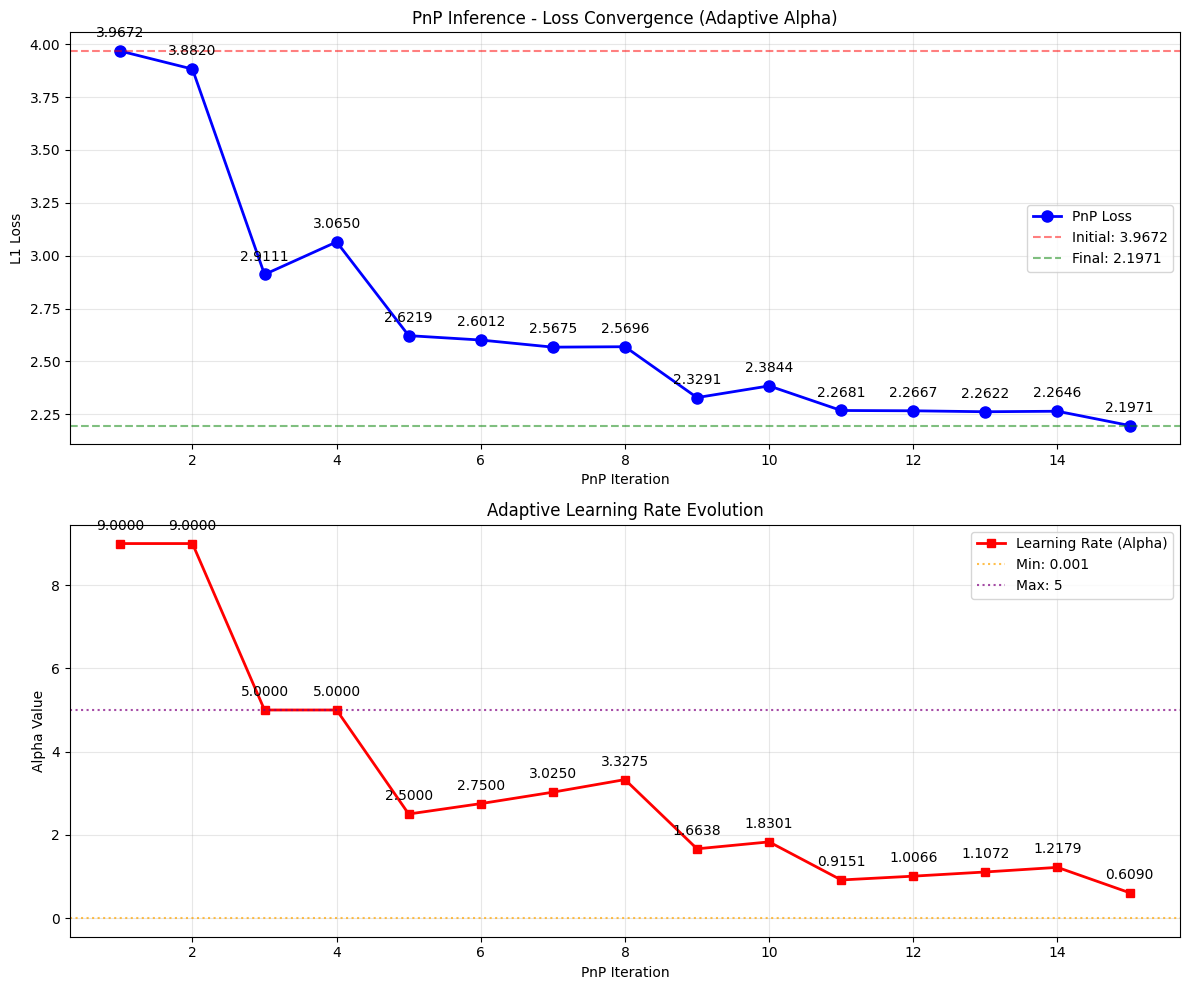

In [6]:
pnp_adaptive, ori_adaptive = pnp_inference_adaptive(
    model=model,
    rgb_input=test_img,
    sparse_depth=test_depth,
    pnp_iters=15,
    pnp_alpha=9,  # Początkowa wartość
    alpha_adaptation=True,  # Włącz adaptację
    alpha_increase_factor=1.1,  # Zwiększaj ostrożnie
    alpha_decrease_factor=0.5,  # Zmniejszaj agresywnie
    min_alpha=0.001,  # Minmalna wartość
    max_alpha=5,  # Maksymalna wartość
    patience=2  # Czekaj 2 iteracje przed zmniejszeniem
)

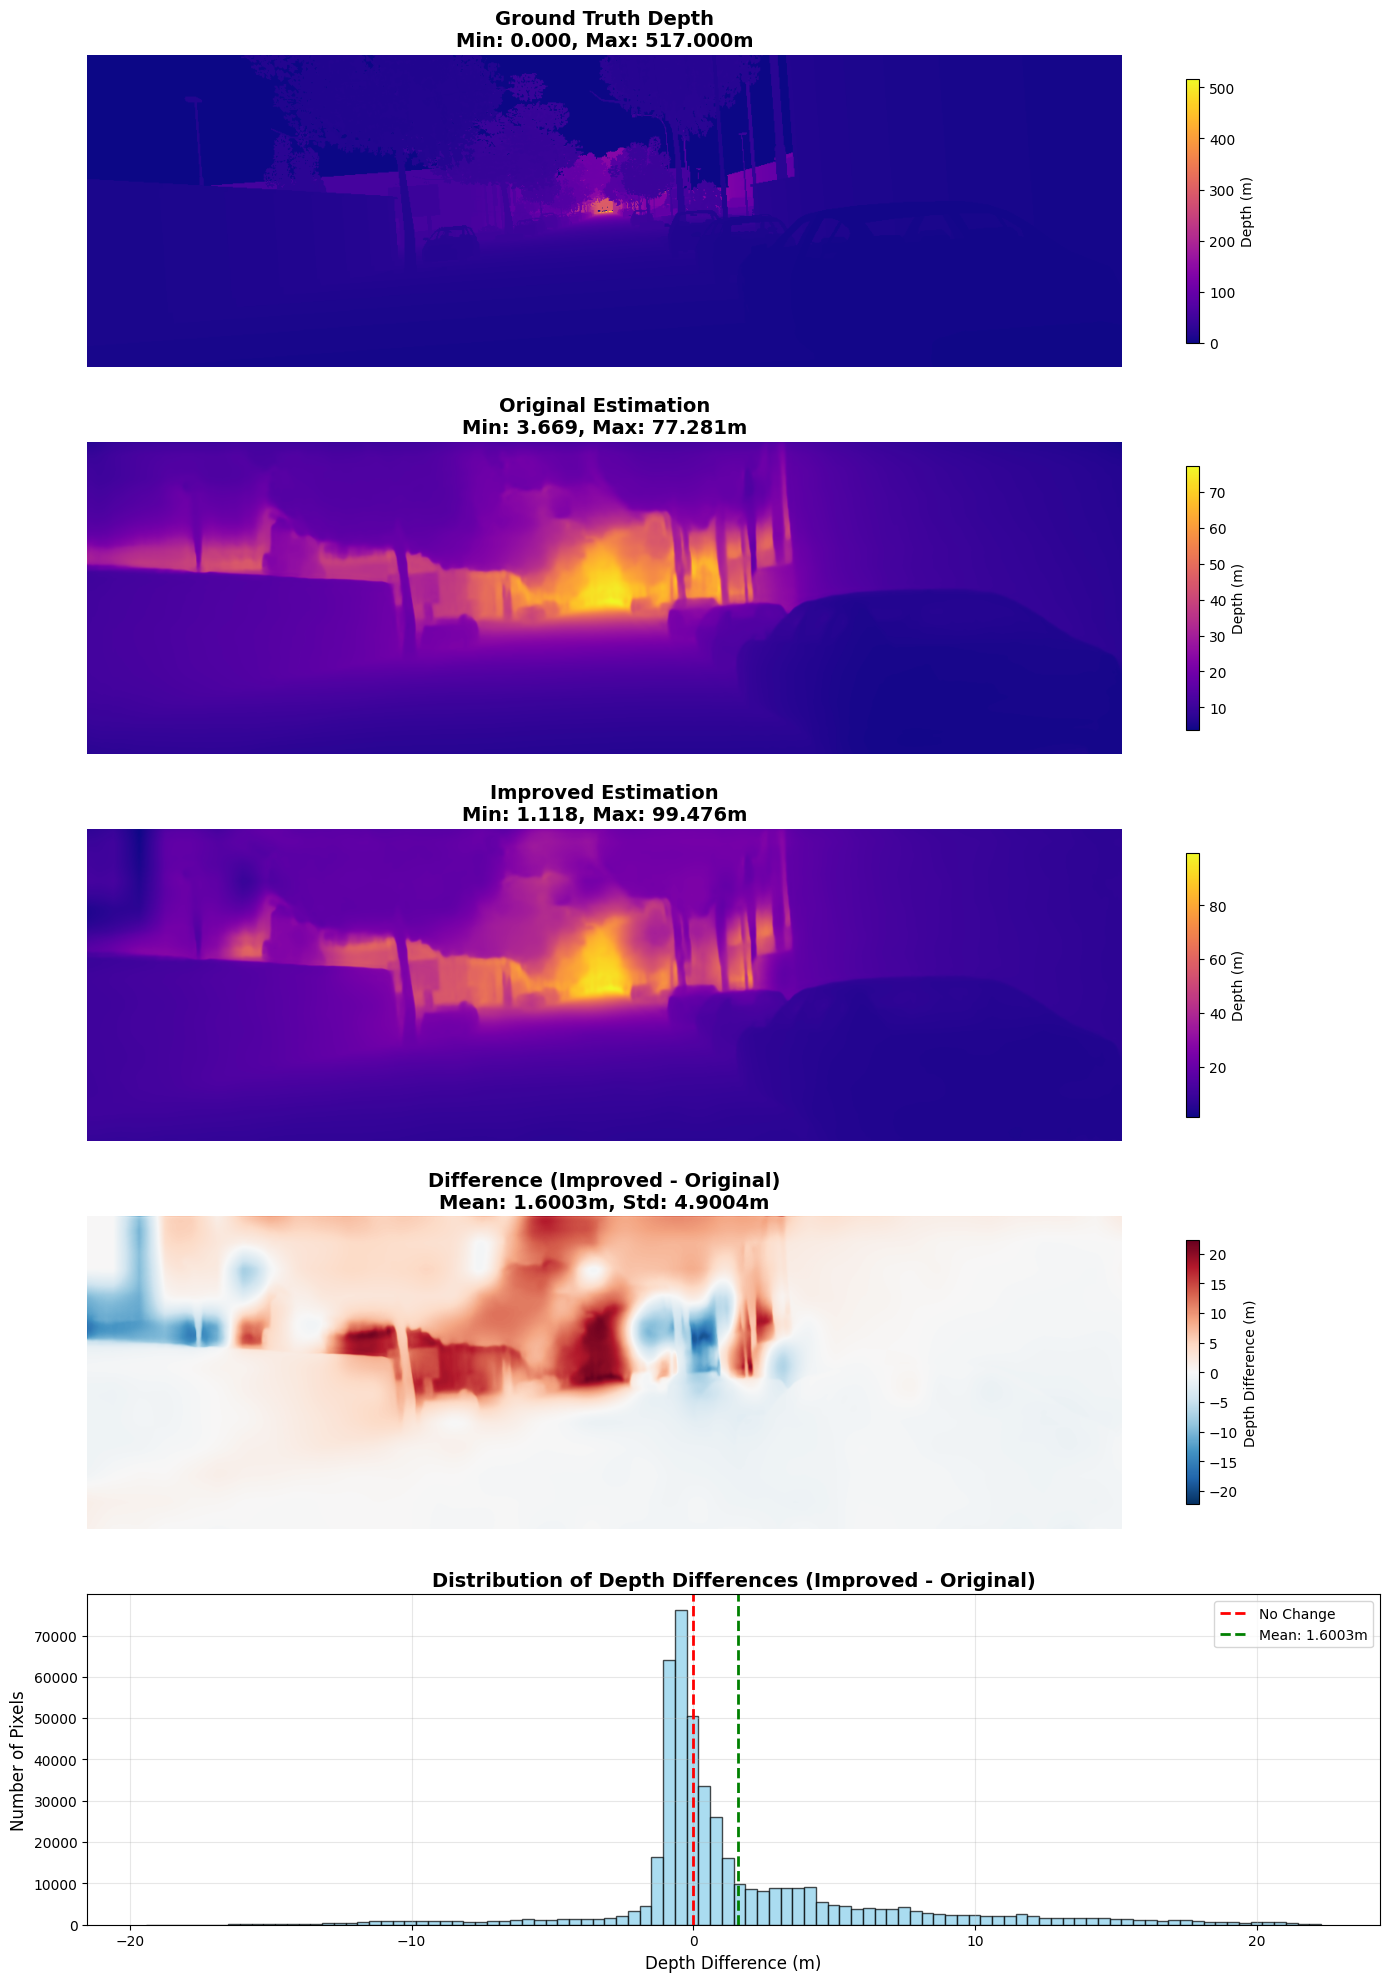


=== DEPTH COMPARISON STATISTICS (Improved) ===
Improved vs Original:
  Mean absolute difference: 2.995327m
  Max positive difference: 22.280167m
  Max negative difference: -19.428669m
  Standard deviation: 4.900418m
  Pixels improved (diff < 0): 47.73%
  Pixels worsened (diff > 0): 51.84%

Original vs Ground Truth:
  Mean absolute error: 6.489010m
  RMSE: 14.677617m

Improved vs Ground Truth:
  Mean absolute error: 5.063378m
  RMSE: 13.663146m

MAE Improvement: 1.425632m (21.97%)


In [7]:
plot_depth_comparison(
    test_depth,
    ori_adaptive['metric_depth'],
    pnp_adaptive['metric_depth'])

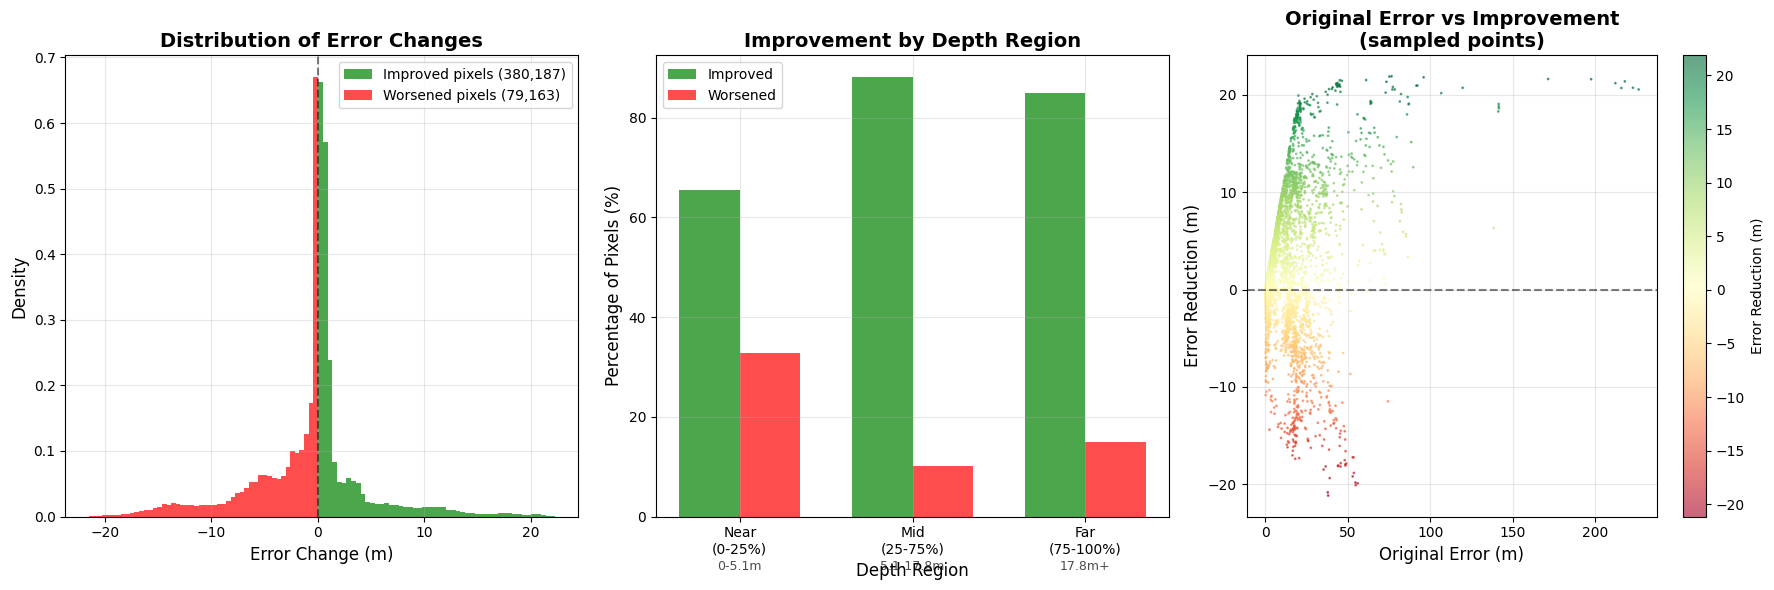


=== REGIONAL ANALYSIS (Improved) ===
Depth quartiles: 5.08m, 10.38m, 17.79m
  Near (0-25%)    (0-5.1m      ):  65.5% improved,  32.7% worsened
  Mid (25-75%)    (5.1-17.8m   ):  88.1% improved,  10.1% worsened
  Far (75-100%)   (17.8m+      ):  84.9% improved,  15.0% worsened


In [8]:
plot_detailed_analysis(test_depth,
                       ori_adaptive['metric_depth'],
                       pnp_adaptive['metric_depth'])